<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/anomalias/src/Anomalias_palanquero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import timedelta
from functools import reduce
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_DADOS_EVENTOS = '/dados/'
PATH_ANOMALIAS = '/anomalias/'
NOMBRE_ESTACION = 'palanquero'
FILE_DATOS_ESTACION = 'eventos_palanquero_2.csv'

LISTA_VAR = ['temp', 'hum', 'pres']
LISTA_PWV = ['pwv']

PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'
FILES_TRATADOS = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR]
FILES_PWV = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PWV]

In [52]:
dfList = []
for f in FILES_TRATADOS:
  df = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(df)

In [63]:
df = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
df = df.sort_values(by=['FECHA']).reset_index(drop = True)
df['HORA'] = df['FECHA'].apply(lambda x: x[11:13])

In [64]:
dfPWV = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + FILES_PWV[0],
                  sep = ';', 
                )

dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()
dfPWV = dfPWV.loc[~dfPWV['PWV'].isnull()].reset_index(drop = True)

dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)

In [76]:
dfDatos = pd.merge(df[['FECHA', 'TEMP', 'HUM', 'PRESION']], dfPWV[['FECHA', 'PWV']], on = 'FECHA', how = 'outer')
dfDatos['HORA'] = dfDatos['FECHA'].apply(lambda x: x[11:13])

dfmean = dfDatos.groupby('HORA', group_keys=False).agg('mean').reset_index(level=0)

columns_mean = [col for col in dfmean.columns if col != 'HORA']
for col in columns_mean:
  dfmean = dfmean.rename(columns={col : f'{col}_mean'})

dfmean

,HORA,TEMP_mean,HUM_mean,PRESION_mean,PWV_mean
0,00,24.602023,93.996656,990.357252,55.670397
1,01,24.310280,94.871467,989.928955,55.334776
2,02,24.065277,95.213324,989.517105,54.783669
3,03,23.824669,95.952575,989.360551,54.348051
4,04,23.624545,95.860717,989.524463,53.916396
5,05,23.476396,96.446680,989.957486,53.633150
6,06,23.392489,96.118200,990.549096,53.486145
7,07,24.552886,94.378837,991.286165,53.349843
8,08,26.403856,86.492383,991.815086,53.023588
9,09,28.146848,79.125812,991.753458,52.845932


In [66]:
dfEventos = pd.read_csv(PATH_DRIVE + PATH_DADOS_EVENTOS + FILE_DATOS_ESTACION, 
                 sep = ';'
                )
dfEventos = dfEventos.sort_values(by='date_min_t').reset_index(drop = True)
dfEventos['FECHA'] = pd.to_datetime(dfEventos['date_min_t'], format='%Y %m %d %H %M').dt.tz_localize('America/Bogota')
dfEventos['FECHA_MIN'] = dfEventos['FECHA'].dt.round('10min')  
dfEventos['FECHA'] = dfEventos['FECHA'].dt.round('H')
dfEventos = dfEventos[['FECHA', 'FECHA_MIN', 'min_t', 'lon_t', 'lat_t']]
dfEventos

,FECHA,FECHA_MIN,min_t,lon_t,lat_t
0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627
1,2011-04-09 23:00:00-05:00,2011-04-09 22:40:00-05:00,197.0,-74.693,5.627
2,2011-05-13 22:00:00-05:00,2011-05-13 22:20:00-05:00,187.8,-74.693,5.627
3,2011-06-06 22:00:00-05:00,2011-06-06 22:20:00-05:00,198.5,-74.693,5.484
4,2011-11-03 02:00:00-05:00,2011-11-03 02:20:00-05:00,191.9,-74.693,5.484
5,2011-11-06 03:00:00-05:00,2011-11-06 02:40:00-05:00,196.4,-74.693,5.627
6,2011-11-28 05:00:00-05:00,2011-11-28 04:40:00-05:00,227.3,-74.693,5.341
7,2011-12-11 03:00:00-05:00,2011-12-11 02:40:00-05:00,199.3,-74.693,5.484
8,2012-03-16 23:00:00-05:00,2012-03-16 22:40:00-05:00,193.6,-74.693,5.484
9,2012-03-20 23:00:00-05:00,2012-03-20 23:20:00-05:00,196.1,-74.693,5.627


In [70]:
funtime = lambda x, hour : [x - timedelta(hours = h) for h in (range(0, hour+1) if hour > 0 else range(hour, 0))]

# [base - datetime.timedelta(days=x) for x in range(numdays)]
dfEventAn = dfEventos.copy()
# pd.set_option('display.max_colwidth', None)
dfEventAn['FECHA_ANTES'] = dfEventAn['FECHA'].apply(funtime, hour = 6)
dfEventAn['FECHA_DESPUES'] = dfEventAn['FECHA'].apply(funtime, hour = -6)
dfEventAn['FECHA_INTERVALO'] = dfEventAn['FECHA_ANTES'] + dfEventAn['FECHA_DESPUES']
dfEventAn = dfEventAn.drop(columns=['FECHA_ANTES', 'FECHA_DESPUES']).explode('FECHA_INTERVALO')
dfEventAn['FECHA_POS'] = (dfEventAn['FECHA_INTERVALO'] - dfEventAn['FECHA'])/ pd.Timedelta(hours=1)
dfEventAn = dfEventAn.rename(columns={'FECHA' : 'FECHA_EVENTO', 'FECHA_INTERVALO': 'FECHA'}).reset_index(drop=True)
dfEventAn['FECHA'] = dfEventAn['FECHA'].astype(str)


dfEventAn.head(15)



,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 23:00:00-05:00,0.0
1,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 22:00:00-05:00,-1.0
2,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 21:00:00-05:00,-2.0
3,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:00:00-05:00,-3.0
4,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:00:00-05:00,-4.0
5,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 18:00:00-05:00,-5.0
6,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 17:00:00-05:00,-6.0
7,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 05:00:00-05:00,6.0
8,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 04:00:00-05:00,5.0
9,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 03:00:00-05:00,4.0


In [84]:
dfCross.HORA.unique()

array(['23', '22', '21', '20', '19', '18', '17', '05', '04', '03', '02',
       '01', '00', '16', '08', '07', '06', '09', '11', '10', '12', '15',
       '14'], dtype=object)

In [99]:
dfCross = pd.merge(dfEventAn, dfDatos, on='FECHA', how = 'left')
dfCross['HORA'] = dfCross['FECHA'].apply(lambda x: x[11:13])
dfCross = pd.merge(dfCross, dfmean, on = 'HORA', how='left')

list_anomalias = []
for col in columns_mean:
  anomalia = f'{col}_anomalia'
  list_anomalias.append(anomalia)
  dfCross[anomalia] = dfCross[f'{col}'] - dfCross[f'{col}_mean'] 

dfAnomalia = dfCross[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()

In [104]:
dfAnomalia

FECHA_POS TEMP_anomalia            ... PRESION_anomalia PWV_anomalia          
                      mean       std  ...              std         mean       std
0         -6      0.053972  1.557917  ...         1.145694     2.152636  4.395274
1         -5      0.108399  1.632155  ...         1.125976     2.183125  4.095265
2         -4      0.226235  1.320779  ...         1.224394     2.751677  3.771588
3         -3      0.349964  1.188915  ...         1.305966     3.256764  3.426964
4         -2      0.457180  1.135485  ...         1.511063     3.491419  3.138265
5         -1      0.393037  1.078524  ...         1.619211     3.484668  3.009741
6          0      0.120684  1.257764  ...         1.795704     2.735343  3.064673
7          1     -0.439633  1.242426  ...         1.762536     1.788008  2.997425
8          2     -0.531372  1.141707  ...         1.902275     1.628800  2.942431
9          3     -0.410947  0.987293  ...         1.845615     1.952666  3.021484
10         4     -0.524259  1.023989  ...         1.892017     2.064888  3.072541
11         5     -0.620014  1.456220  ...         1.886782     2.352379  2.969057
12         6     -0.558957  1.609900  ...         1.850859     2.493826  3.101611

[13 rows x 9 columns]

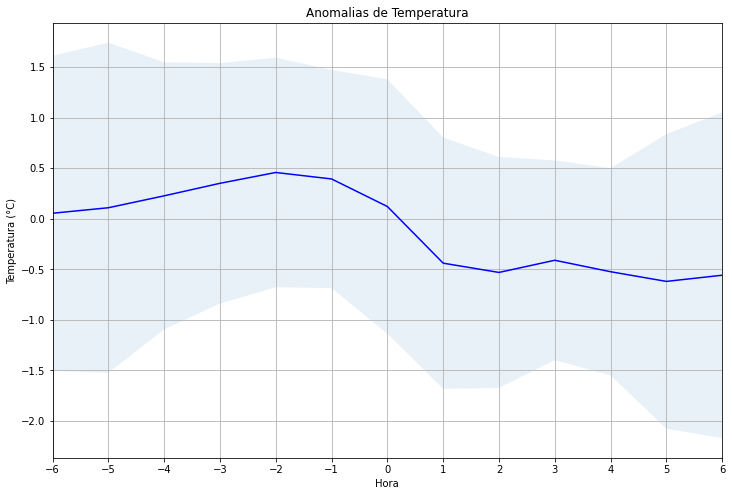

<Figure size 432x288 with 0 Axes>

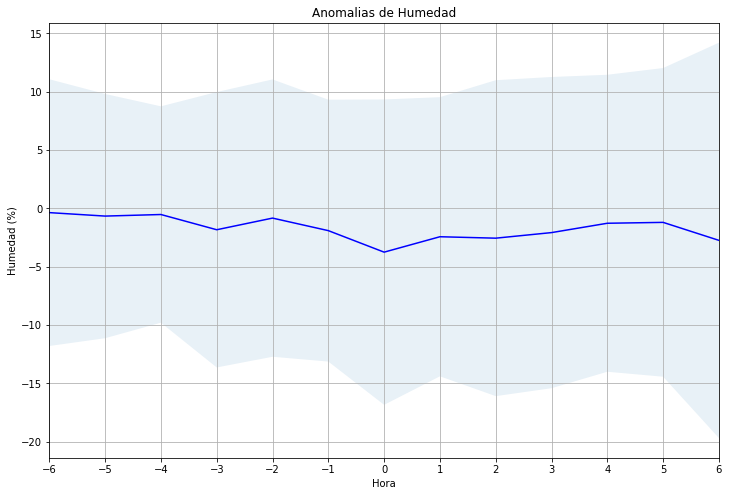

<Figure size 432x288 with 0 Axes>

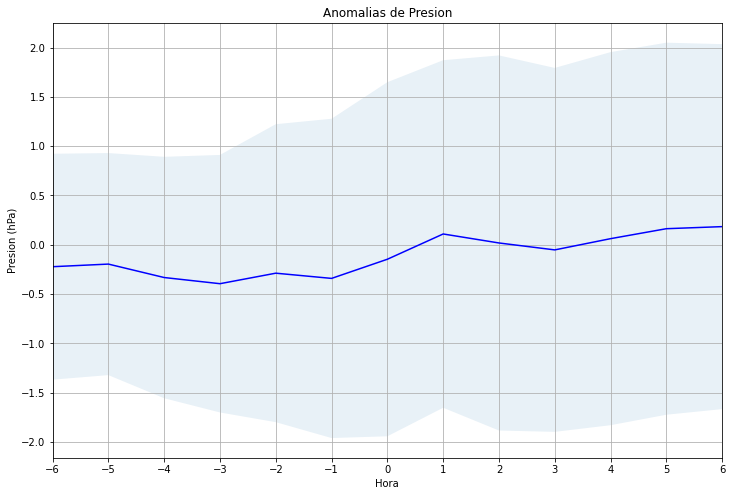

<Figure size 432x288 with 0 Axes>

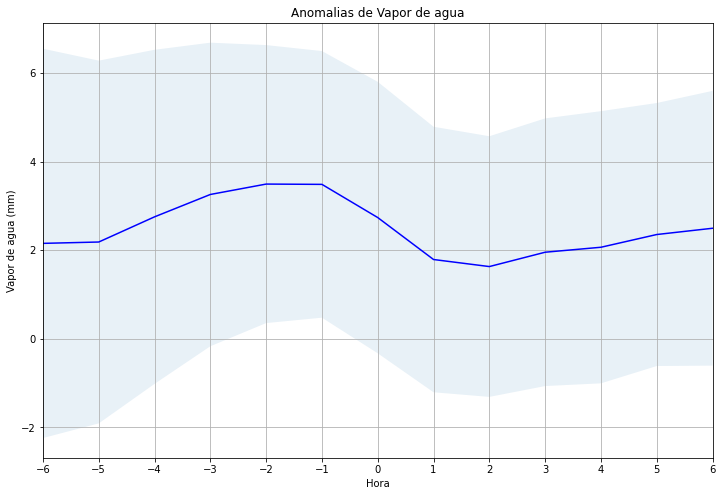

<Figure size 432x288 with 0 Axes>

In [106]:
def plot_anomalias(df, anomalia, titulo, name_to_save, ylabel_name, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)

  plt.xticks(df['FECHA_POS'])
  plt.plot(df['FECHA_POS'], df[(anomalia, 'mean')], color = 'b')
  plt.fill_between(df['FECHA_POS'], df[(anomalia, 'mean')] + df[(anomalia, 'std')], df[(anomalia, 'mean')] - df[(anomalia, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.grid()
  plt.xlim([-6, 6])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Hora")
  plt.ylabel(ylabel_name)
  plt.title(titulo)
  plt.show()

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : 'anomalias_temperatura.png', 'ylabel' : 'Temperatura (°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : 'anomalias_humedad.png', 'ylabel' : 'Humedad (%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : 'anomalias_presion.png', 'ylabel' : 'Presion (hPa)'},
              'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : 'anomalias_pwv.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomalia, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'])

# dfAnomalia